In [18]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [66]:
df = pd.read_csv("kag_risk_factors_cervical_cancer.csv")
df.info()
pd.set_option('display.max_columns', None)
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 858 non-null    int64 
 1   Number of sexual partners           858 non-null    object
 2   First sexual intercourse            858 non-null    object
 3   Num of pregnancies                  858 non-null    object
 4   Smokes                              858 non-null    object
 5   Smokes (years)                      858 non-null    object
 6   Smokes (packs/year)                 858 non-null    object
 7   Hormonal Contraceptives             858 non-null    object
 8   Hormonal Contraceptives (years)     858 non-null    object
 9   IUD                                 858 non-null    object
 10  IUD (years)                         858 non-null    object
 11  STDs                                858 non-null    object

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0


In [67]:
#data imputation

mean_array = ['Age','Number of sexual partners','First sexual intercourse','Num of pregnancies','Smokes (years)','Smokes (packs/year)','Hormonal Contraceptives (years)','IUD (years)','STDs (number)','STDs: Time since first diagnosis','STDs: Time since last diagnosis']
for col in df.columns:
    # target = ['Hinselmann','Schiller','Citology','Biopsy']
    if col in mean_array:
        df[col] = df[col].replace('?',None)
        df[col] = df[col].astype(float)
        mean = df[col].mean(skipna=True)
        df.fillna(mean, inplace=True)
    elif col not in mean_array:
        df[col] = df[col].replace('?',None)
        df[col] = df[col].astype(float)
        mode = df[col].mode()
        df.fillna(mode,inplace=True)

In [68]:
#removing outliers

columns = ['Age', 'Number of sexual partners', 'First sexual intercourse']

# Calculate the IQR for each column and remove outliers
for column in columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    df = df.loc[(df[column] >= Q1 - 1.5*IQR) & (df[column] <= Q3 + 1.5*IQR)]

In [69]:
# normalizing the data
columns_to_normalize = ['Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs (number)','STDs: Time since first diagnosis','STDs: Time since last diagnosis']

# Create MinMaxScaler object
for col in columns_to_normalize:
    df[col] = (df[col]-np.min(df[col]))/(np.max(df[col])-np.min(df[col]))

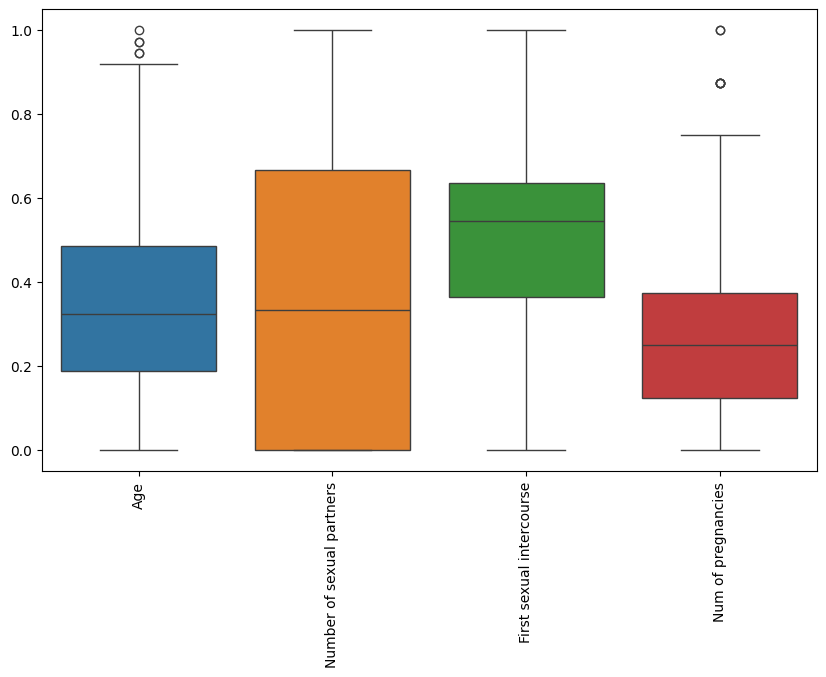

In [70]:
cols_to_plot = ['Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies']

# Create boxplots of the selected columns
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=df[cols_to_plot], ax=ax)
plt.xticks(rotation=90)
plt.show()

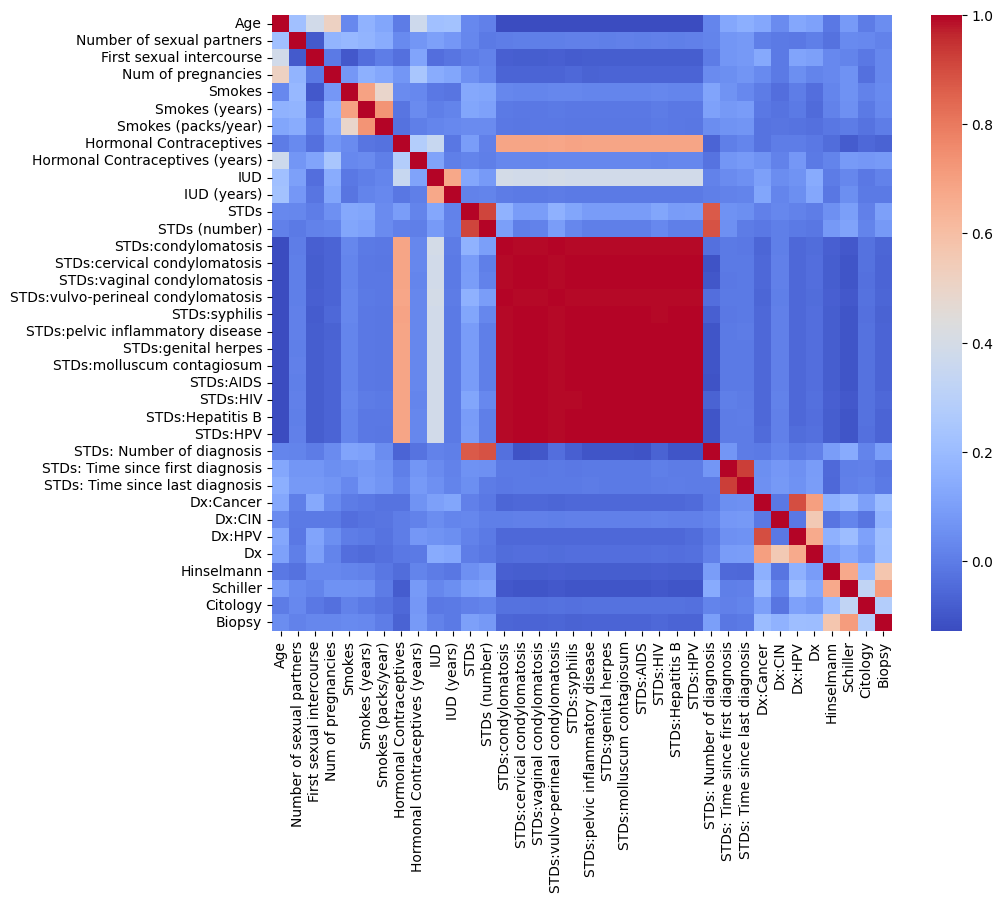

In [71]:
# Calculate the correlation matrix

corr_matrix = df.corr()

# Create a correlation heatmap
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

In [72]:
target_columns = ['Hinselmann', 'Schiller', 'Citology', 'Biopsy']

# Prepare the target variables
Y_1 = df['Hinselmann']
Y_2 = df['Schiller']
Y_3 = df['Citology']
Y_4 = df['Biopsy']

# --- PCA and Train-Test Split for each target ---

# Hinselmann
print("Processing for Hinselmann...")
# Features for Hinselmann: drop only 'Hinselmann' from df
X_features_1 = df.drop(columns=['Hinselmann'])
pca_1 = PCA(n_components=15)
X_pca_1 = pd.DataFrame(pca_1.fit_transform(X_features_1))
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_pca_1, Y_1, test_size=0.2, random_state=42)

# Schiller
print("Processing for Schiller...")
# Features for Schiller: drop only 'Schiller' from df
X_features_2 = df.drop(columns=['Schiller'])
pca_2 = PCA(n_components=15)
X_pca_2 = pd.DataFrame(pca_2.fit_transform(X_features_2))
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_pca_2, Y_2, test_size=0.2, random_state=42)

# Citology
print("Processing for Citology...")
# Features for Citology: drop only 'Citology' from df
X_features_3 = df.drop(columns=['Citology'])
pca_3 = PCA(n_components=15)
X_pca_3 = pd.DataFrame(pca_3.fit_transform(X_features_3))
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_pca_3, Y_3, test_size=0.2, random_state=42)

# Biopsy
print("Processing for Biopsy...")
# Features for Biopsy: drop only 'Biopsy' from df
X_features_4 = df.drop(columns=['Biopsy'])
pca_4 = PCA(n_components=15)
X_pca_4 = pd.DataFrame(pca_4.fit_transform(X_features_4))
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_pca_4, Y_4, test_size=0.2, random_state=42)

print("\n--- Applying SMOTE to Training Data ---")
# Define SMOTE
smote = SMOTE(random_state=42) # Added random_state for reproducibility

# Apply SMOTE to the training data for each target
X_train_1, y_train_1 = smote.fit_resample(X_train_1, y_train_1)
X_train_2, y_train_2 = smote.fit_resample(X_train_2, y_train_2)
X_train_3, y_train_3 = smote.fit_resample(X_train_3, y_train_3)
X_train_4, y_train_4 = smote.fit_resample(X_train_4, y_train_4)

print("SMOTE applied for all training sets.")


Processing for Hinselmann...
Processing for Schiller...
Processing for Citology...
Processing for Biopsy...

--- Applying SMOTE to Training Data ---
SMOTE applied for all training sets.


In [64]:
#PCA
cov_mat = np.cov(df.T)

# Compute the eigenvectors and eigenvalues of the covariance matrix
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

num_cols = df.drop(columns = ['Hinselmann','Schiller','Citology','Biopsy']).columns

pca = PCA(n_components=15)
X = pd.DataFrame(pca.fit_transform(df[num_cols]))

# Transform the data into the new feature space

# X_1 = X.copy()
Y_1 = df['Hinselmann']

# X_2 = X.copy()
Y_2 = df['Schiller']

# X_3 = X.copy()
Y_3 = df['Citology']

# X_4 = X.copy()
Y_4 = df['Biopsy']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, Y_1, test_size=0.2, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, Y_2, test_size=0.2, random_state=42)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, Y_3, test_size=0.2, random_state=42)
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, Y_4, test_size=0.2, random_state=42)

# define SMOTE
smote = SMOTE()

# apply SMOTE to the training data
X_train_1, y_train_1 = smote.fit_resample(X_train_1, y_train_1)
X_train_2, y_train_2 = smote.fit_resample(X_train_2, y_train_2)
X_train_3, y_train_3 = smote.fit_resample(X_train_3, y_train_3)
X_train_4, y_train_4 = smote.fit_resample(X_train_4, y_train_4)


SVM - Validation Accuracy for Hinselmann: 96.0
SVM - Validation Precision for Hinselmann: 60.0
SVM - Validation Recall for Hinselmann: 100.0


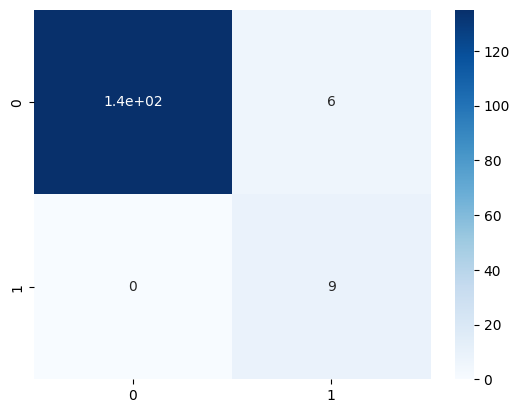



SVM - Validation Accuracy for Schiller: 94.0
SVM - Validation Precision for Schiller: 63.63636363636363
SVM - Validation Recall for Schiller: 93.33333333333333


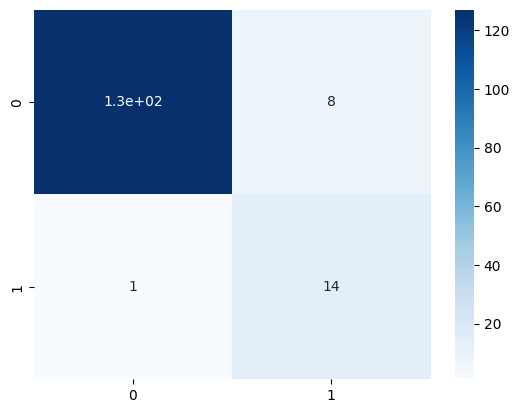



SVM - Validation Accuracy for Citology: 89.33333333333333
SVM - Validation Precision for Citology: 20.0
SVM - Validation Recall for Citology: 42.857142857142854


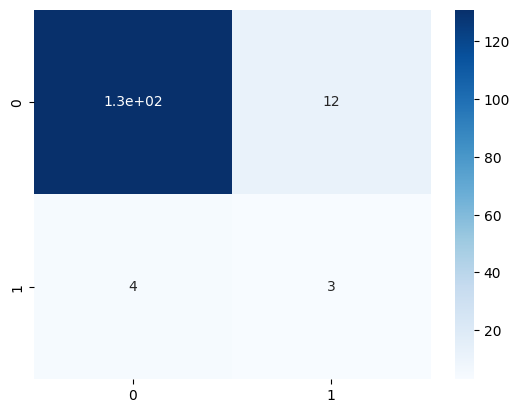



SVM - Validation Accuracy for Biopsy: 98.0
SVM - Validation Precision for Biopsy: 87.5
SVM - Validation Recall for Biopsy: 93.33333333333333


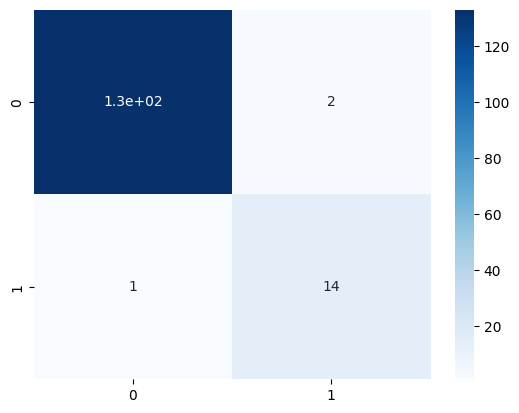



KNN - Validation Accuracy for Hinselmann: 94.66666666666667
KNN - Validation Precision for Hinselmann: 53.333333333333336
KNN - Validation Recall for Hinselmann: 88.88888888888889


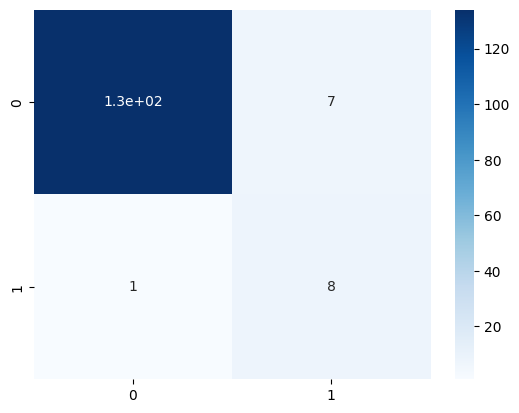



KNN - Validation Accuracy for Schiller: 88.66666666666667
KNN - Validation Precision for Schiller: 46.15384615384615
KNN - Validation Recall for Schiller: 80.0


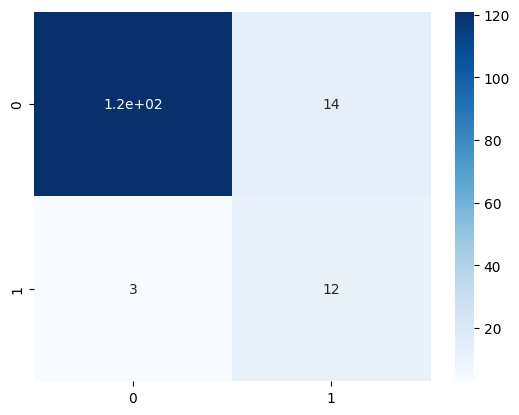



KNN - Validation Accuracy for Citology: 82.66666666666667
KNN - Validation Precision for Citology: 8.695652173913043
KNN - Validation Recall for Citology: 28.57142857142857


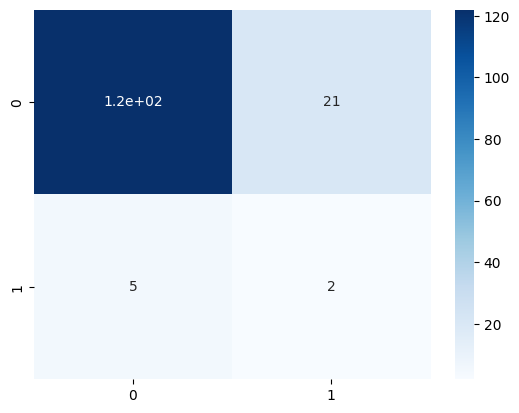



KNN - Validation Accuracy for Biopsy: 94.66666666666667
KNN - Validation Precision for Biopsy: 66.66666666666666
KNN - Validation Recall for Biopsy: 93.33333333333333


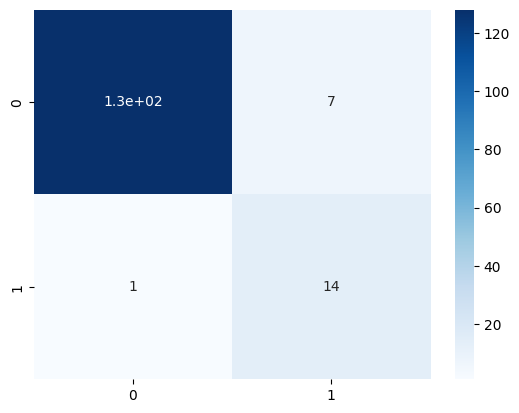

In [73]:
# Train and evaluate the SVM classifier
svm_clf = SVC(C=1.0, kernel='rbf')
svm_clf.fit(X_train_1, y_train_1)
y_pred_val_svm = svm_clf.predict(X_test_1)
acc_svm = accuracy_score(y_test_1, y_pred_val_svm)
prec_svm = precision_score(y_test_1, y_pred_val_svm, zero_division=1)
rec_svm = recall_score(y_test_1, y_pred_val_svm)

print("SVM - Validation Accuracy for Hinselmann:", acc_svm*100)
print("SVM - Validation Precision for Hinselmann:", prec_svm*100)
print("SVM - Validation Recall for Hinselmann:", rec_svm*100)

cm = confusion_matrix(y_test_1, y_pred_val_svm)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.show()
print("\n")

svm_clf = SVC(C=1.0, kernel='rbf')
svm_clf.fit(X_train_2, y_train_2)
y_pred_val_svm = svm_clf.predict(X_test_2)
acc_svm = accuracy_score(y_test_2, y_pred_val_svm)
prec_svm = precision_score(y_test_2, y_pred_val_svm, zero_division=1)
rec_svm = recall_score(y_test_2, y_pred_val_svm)

print("SVM - Validation Accuracy for Schiller:", acc_svm*100)
print("SVM - Validation Precision for Schiller:", prec_svm*100)
print("SVM - Validation Recall for Schiller:", rec_svm*100)

cm = confusion_matrix(y_test_2, y_pred_val_svm)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.show()
print("\n")


svm_clf = SVC(C=1.0, kernel='rbf')
svm_clf.fit(X_train_3, y_train_3)
y_pred_val_svm = svm_clf.predict(X_test_3)
acc_svm = accuracy_score(y_test_3, y_pred_val_svm)
prec_svm = precision_score(y_test_3, y_pred_val_svm, zero_division=1)
rec_svm = recall_score(y_test_3, y_pred_val_svm)

print("SVM - Validation Accuracy for Citology:", acc_svm*100)
print("SVM - Validation Precision for Citology:", prec_svm*100)
print("SVM - Validation Recall for Citology:", rec_svm*100)
cm = confusion_matrix(y_test_3, y_pred_val_svm)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.show()
print("\n")

svm_clf = SVC(C=1.0, kernel='rbf')
svm_clf.fit(X_train_4, y_train_4)
y_pred_val_svm = svm_clf.predict(X_test_4)
acc_svm = accuracy_score(y_test_4, y_pred_val_svm)
prec_svm = precision_score(y_test_4, y_pred_val_svm, zero_division=1)
rec_svm = recall_score(y_test_4, y_pred_val_svm)

print("SVM - Validation Accuracy for Biopsy:", acc_svm*100)
print("SVM - Validation Precision for Biopsy:", prec_svm*100)
print("SVM - Validation Recall for Biopsy:", rec_svm*100)
cm = confusion_matrix(y_test_4, y_pred_val_svm)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.show()
print("\n")

# Train and evaluate the KNN classifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_1, y_train_1)
y_pred_val_knn = knn_clf.predict(X_test_1)
acc_knn = accuracy_score(y_test_1, y_pred_val_knn)
prec_knn = precision_score(y_test_1, y_pred_val_knn, zero_division=1)
rec_knn = recall_score(y_test_1, y_pred_val_knn)

print("KNN - Validation Accuracy for Hinselmann:", acc_knn*100)
print("KNN - Validation Precision for Hinselmann:", prec_knn*100)
print("KNN - Validation Recall for Hinselmann:", rec_knn*100)
cm = confusion_matrix(y_test_1, y_pred_val_knn)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.show()
print("\n")

knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_2, y_train_2)
y_pred_val_knn = knn_clf.predict(X_test_2)
acc_knn = accuracy_score(y_test_2, y_pred_val_knn)
prec_knn = precision_score(y_test_2, y_pred_val_knn, zero_division=1)
rec_knn = recall_score(y_test_2, y_pred_val_knn)

print("KNN - Validation Accuracy for Schiller:", acc_knn*100)
print("KNN - Validation Precision for Schiller:", prec_knn*100)
print("KNN - Validation Recall for Schiller:", rec_knn*100)
cm = confusion_matrix(y_test_2, y_pred_val_knn)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.show()
print("\n")

knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_3, y_train_3)
y_pred_val_knn = knn_clf.predict(X_test_3)
acc_knn = accuracy_score(y_test_3, y_pred_val_knn)
prec_knn = precision_score(y_test_3, y_pred_val_knn, zero_division=1)
rec_knn = recall_score(y_test_3, y_pred_val_knn)

print("KNN - Validation Accuracy for Citology:", acc_knn*100)
print("KNN - Validation Precision for Citology:", prec_knn*100)
print("KNN - Validation Recall for Citology:", rec_knn*100)
cm = confusion_matrix(y_test_3, y_pred_val_knn)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.show()
print("\n")

knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_4, y_train_4)
y_pred_val_knn = knn_clf.predict(X_test_4)
acc_knn = accuracy_score(y_test_4, y_pred_val_knn)
prec_knn = precision_score(y_test_4, y_pred_val_knn, zero_division=1)
rec_knn = recall_score(y_test_4, y_pred_val_knn)

print("KNN - Validation Accuracy for Biopsy:", acc_knn*100)
print("KNN - Validation Precision for Biopsy:", prec_knn*100)
print("KNN - Validation Recall for Biopsy:", rec_knn*100)
cm = confusion_matrix(y_test_4, y_pred_val_knn)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.show()
print("\n")

--------------------------------------------------
Value-Counts: Before
Biopsy
0.0    567
1.0     31
Name: count, dtype: int64
Value-Counts: After
Biopsy
0.0    567
1.0    567
Name: count, dtype: int64
--------------------------------------------------
On Train Data ===>
ACC : 0.9541446208112875
Classification Report
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       567
         1.0       0.95      0.95      0.95       567

    accuracy                           0.95      1134
   macro avg       0.95      0.95      0.95      1134
weighted avg       0.95      0.95      0.95      1134

Confusion Matrix


<Axes: >

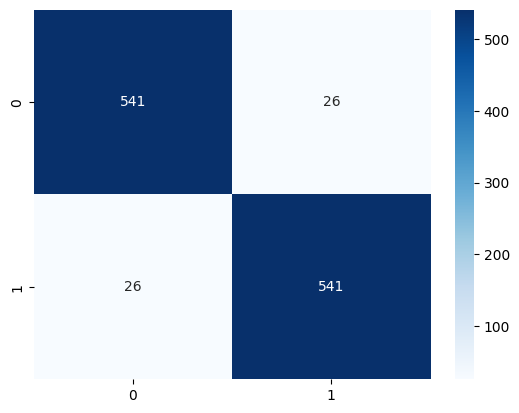


--------------------------------------------------
On Test Data ===>
ACC : 0.98
Classification Report
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       135
         1.0       0.88      0.93      0.90        15

    accuracy                           0.98       150
   macro avg       0.93      0.96      0.95       150
weighted avg       0.98      0.98      0.98       150

Confusion Matrix


<Axes: >

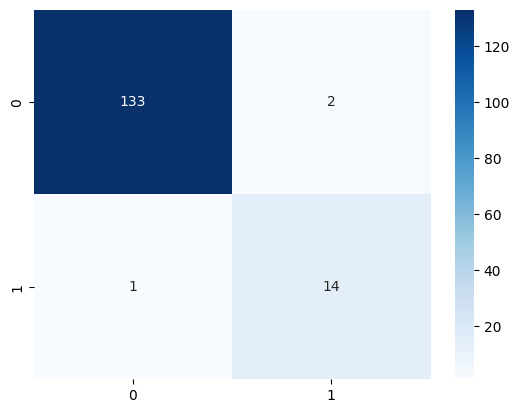

In [59]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = df.drop(['Biopsy'], axis=1)
y = df['Biopsy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

print('-'*50)
print("Value-Counts: Before")
print(y_train.value_counts())

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

print("Value-Counts: After")
print(y_train.value_counts())

model = svm.SVC()
model.fit(X_train, y_train)

print('-'*50)

print("On Train Data ===>")

y_pred = model.predict(X_train)
print(f"ACC : {accuracy_score(y_train, y_pred)}")
print(f"Classification Report")
print(classification_report(y_train, y_pred))
print(f"Confusion Matrix")
display(sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, cmap='Blues', fmt='d'))
plt.show()

print()
print('-'*50)
print("On Test Data ===>")

y_pred = model.predict(X_test)
print(f"ACC : {accuracy_score(y_test, y_pred)}")
print(f"Classification Report")
print(classification_report(y_test, y_pred))
print(f"Confusion Matrix")
display(sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='d'))